In [ ]:

#Standard Imports
import yfinance as yf
import datetime
import numpy as np
from tensorflow import keras
import pandas as pd


#need to create a time period for 2000's - yesterday for out training data
today = datetime.date.today()
yesterday = today - datetime.timedelta(days = 1)
twenty_years = 365*20
past_20 = today - datetime.timedelta(days=twenty_years)

#prompt user for ticker
ticker = input("Enter your ticker: ")
ticker = ticker.upper()
Tickerdata = yf.download(ticker, start = past_20, end = yesterday) 

#Validates that a ticker has populated the DF
while len(Tickerdata) == 0:
    ticker = input("Invalid Ticker, Please Enter a Valid Ticker: ")
    ticker = ticker.upper()
    Tickerdata = yf.download(ticker, start = past_20 , end = yesterday) 

#prompt for monthly contribution and validates entry is integer
contrib = input("Enter your monthly contribution amount")
while contrib.isdigit() == False:
    contrib = input("Please enter a valid integer for monthly contribution amount")
contrib = int(contrib)


#Feature engineering

#Tickerdata['IDE'] = Tickerdata['next_day_close'] - Tickerdata['Close'][ticker] #intraday earnings

#Add features based on the Date
Tickerdata['Weekday'] = Tickerdata.index.day_of_week
Tickerdata['Month'] = Tickerdata.index.month
Tickerdata['Year'] = Tickerdata.index.year
Tickerdata['Days_Since_Start'] = (Tickerdata.index - Tickerdata.index[0]).days #days since start tracking
Tickerdata['Years_Since_Start'] = Tickerdata['Days_Since_Start']/365

#Targer will be Log_Close for more additive predictions rather than multiplicative
Tickerdata['Log_Close'] = np.log(Tickerdata['Close'])

#Add features based on performance

Tickerdata['SMA_30'] = Tickerdata['Close'].rolling(window = 30).mean()
Tickerdata['SMA_200'] = Tickerdata['Close'].rolling(window = 200).mean() #200 day moving average using the rolling function, will create NANS that we will drop
Tickerdata['SMA_500'] = Tickerdata['Close'].rolling(window = 500).mean()
Tickerdata['volatility'] = Tickerdata['Close'].rolling(window=200).std()



#https://medium.com/thedeephub/mastering-time-series-forecasting-revealing-the-power-of-fourier-terms-in-arima-d34a762be1ce
#Need Seasonality to shape our forecast
def add_fourier_terms(df, period=252, ): #order will be our number of fourier terms, in this case 3
    t = np.arange(len(df))
    df['sin_1'] = np.sin(2 * np.pi * 1 * t / period) 
    df['cos_1'] = np.cos(2 * np.pi * 1 * t / period)
    df['sin_2'] = np.sin(2 * np.pi * 2 * t / period) 
    df['cos_2'] = np.cos(2 * np.pi * 2 * t / period)
    df['sin_3'] = np.sin(2 * np.pi * 2 * t / period) 
    df['cos_3'] = np.cos(2 * np.pi * 2 * t / period)
   
    df['sin_4'] = np.sin(2 * np.pi * 4 * t / period) 
    df['cos_4'] = np.cos(2 * np.pi * 4 * t / period)

    return df

Tickerdata = add_fourier_terms(Tickerdata, period=252)
Tickerdata.dropna(inplace=True)




## Fourier Terms

t - time index(days since start)
period - one trading year
i-number of waves 1st,2nd,3rd | Changes the frequency of the sine and cosine waves, 1 wave (252 days one full trading year), 2 waves(semmi annual) 4 waves(Quarterly)

This will help during forecasting dating rather than model training, as it will give a shape to the data that is more fit to the seasons


### EXAMPLE WITHOUT FOURIER TERMS ON AAPL Forecast
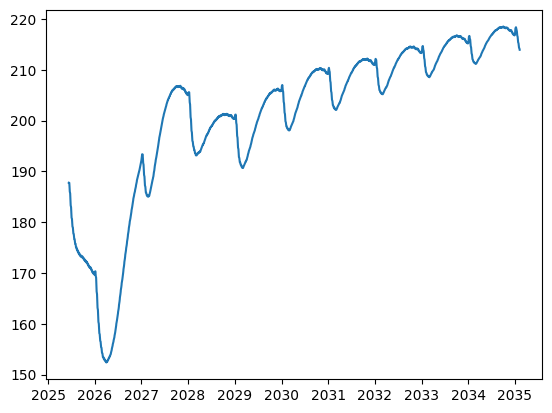
Only observable seasonality is annual, roughly same shape repeated every year with little variation


### Example WITH FOURIER TERMS ON AAPL FORECAST
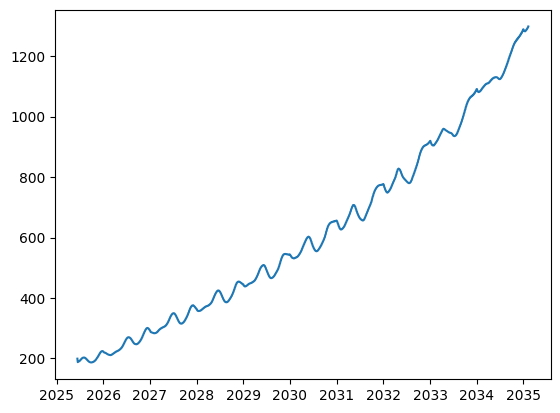

Data varies throughout the year less repetitive,  differences in shape every year

In [ ]:
#Simple Linear Regression Model That will establish a stable long term trend
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

linx = Tickerdata[['Years_Since_Start']]
liny = Tickerdata['Log_Close']

linx_train,linx_test, liny_train,liny_test = train_test_split(linx, liny, test_size= .2, shuffle=False) #do not shuffle for time series data
linreg_model = LinearRegression().fit(linx_train, liny_train)
log_test = linreg_model.predict(linx_test)
price_pred = np.exp(log_test)

from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_percentage_error
print("lin model R2: ", r2_score(np.exp(liny_test), price_pred ))

rmse = root_mean_squared_error(np.exp(liny_test), price_pred)
print("RMSE:", rmse)
mape = mean_absolute_percentage_error(np.exp(liny_test), price_pred)
print("MAPE: ",mape*100,"%")



year = Tickerdata['Years_Since_Start'].iloc[-1]

Decade = np.array([[year+10]])

future_log = linreg_model.predict(Decade)

future_price = np.exp(future_log)[0]

print('Future Price Predicted: ',future_price)

current_price = Tickerdata['Close'].iloc[-1][0]

CAGR = (future_price/current_price)**(1/10)  - 1

print('Compound Annual Growth Rate: ', CAGR)

In [ ]:
short_term_features = ['Weekday', 'Month', 'Open', "Years_Since_Start", "Days_Since_Start", "SMA_200", "SMA_500",'sin_1', 'sin_2','sin_3' ,'sin_4', 'cos_1', 'cos_2','cos_3', 'cos_4']
x = Tickerdata[short_term_features]
y = Tickerdata['Log_Close'].values.reshape(-1, 1) 

from sklearn.preprocessing import StandardScaler
xscaler = StandardScaler()
yscaler = StandardScaler()
xscale= xscaler.fit_transform(x)
yscale = yscaler.fit_transform(y)

window = int(len(Tickerdata)/2) #Need a large window size, this will improve model performance


def train_lstm(x, y, window):
    x_lstm, y_lstm = [], []
    for i in range(window, len(x)):
        x_lstm.append(x[i-window:i])
        y_lstm.append(y[i]) 
        # creates window sized chunks ,overlapping one day at a time until the last day of the dataframe for x to predict the end window sized chunk of y
    return np.array(x_lstm), np.array(y_lstm)
x_lstm, y_lstm = train_lstm(xscale, yscale, window)

x_train,x_test,y_train,y_test = train_test_split(x_lstm, y_lstm, test_size=.2, shuffle=False)


model = keras.models.Sequential()
model.add(keras.layers.LSTM(128, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2]))) 
#model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.LSTM(128, return_sequences=True )) 
#model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.LSTM(128, return_sequences=False )) 
#model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['mean_absolute_percentage_error'])
model.summary()




In [ ]:
import tensorflow as tf
hist = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=.3, verbose=1)#,callbacks =
                
  #  [tf.keras.callbacks.EarlyStopping(
  #  monitor = 'val_mean_absolute_percentage_error', mode = 'min',
  #  patience = 10,
  #  restore_best_weights = True
  #  )])

y_pred = model.predict(x_test)
y_pred_real = yscaler.inverse_transform(y_pred)
y_test_real = yscaler.inverse_transform(y_test.reshape(-1, 1))
import matplotlib.pyplot as plt
plt.plot(np.exp(y_test_real), label='Actual')
plt.plot(np.exp(y_pred_real), label='Predicted')
plt.title("LSTM: Actual vs Predicted Prices")
plt.legend()
plt.xlabel('Trading Days in Training Set')
plt.ylabel('close price')
plt.show()

LSTM_rmse = root_mean_squared_error(np.exp(y_test_real),np.exp(y_pred_real))
LSTM_r2 = r2_score(np.exp(y_test_real),np.exp(y_pred_real))
LSTM_mape = mean_absolute_percentage_error(np.exp(y_test_real),np.exp(y_pred_real))

print(f"RMSE:" ,rmse)   

print(f"R2: ", LSTM_r2)
print('MAPE:', LSTM_mape*100,"%")

In [ ]:
#Need a recent CAGR For our Forecasting Trend:
lookback_days = 1260 
recent_data = Tickerdata.iloc[-lookback_days:]

start_price = recent_data['Close'].iloc[-365]
end_price = recent_data['Close'].iloc[-1]
years = (recent_data.index[-1] - recent_data.index[0]).days / 365

cagr = (end_price / start_price) ** (1 / years) - 1
log_cagr = np.log(1 + cagr)

### Setting a Trend 

We need to set a trend for our forecast, if we do not do that our forecasted data will hover around the same prices (the more recent prices collected during the window, which is why we also set a very wide window during the train-test-split). We are going to set a trend based on the Compound Annual Growth Rate (CAGR) of our ticker for the past 5 years of its history, this way the trend can be organic to each ticker.

For the Code below, we are attempting to create a loop that will forecast the price of our ticker 10 years into the future using the predict method. We will need to first feed it recent values, since our SMA_500 requires the largest amount of data, we will give it a dataset of the past 500 days. Forecasting features will be the same as our prediction features (reason I have two different variables is because I at one point experimented with trying different feature sets for forecasting and model training). 

Our forecast loop will need to loop over 2520 TRADING DAYS, so we will need to add a feature to skip weekends, reshape our data into an array again to feed into our LSTM predictor (just like we did above) 

In [ ]:
from datetime import timedelta
import numpy as np


#We need a list of opening prices that our forecasting will work on
pricehist = Tickerdata['Open'].iloc[:,0]
pricehist = pricehist.iloc[-500:]
pricehist = pd.Series(pricehist)
pricehist = list(pricehist)

forecast_features = [
                    'Weekday', 'Month', 'Open', "Years_Since_Start", "Days_Since_Start", "SMA_200", "SMA_500", 'sin_1', 'sin_2','sin_3', 'sin_4', 'cos_1', 'cos_2','cos_3', 'cos_4'
    ]


window = 252
forecast_days = 2520

#use some of our old data
feature_hist = xscale[-window:] 

last_day_count = Tickerdata['Days_Since_Start'].iloc[-1]
total_years = Tickerdata['Years_Since_Start'].iloc[-1]
date = Tickerdata.index[-1]
SMA_200 = np.mean(pricehist[-200:])
SMA_500=  np.mean(pricehist[-500:])


future_dates = []
pred_log = []
pred_price = []


#create a daily trend variable to add a trend to the data 



for i in range(forecast_days):
    #NEED this if statement, otherwise our first day dramatically trends downward on the first forecasted day, we will just append the last close price & not do anything else
    if i == 0:
        date += timedelta(days=1)
        while date.weekday() > 4:
            date += timedelta(days=1)

        log_real = np.log(Tickerdata['Close'].iloc[-1])
        log_real_trend = log_real # no trend on day 1
        pred_log.append(log_real)
        pred_price.append(np.exp(log_real_trend))
        future_dates.append(date)  
        continue
    #skip non trading days
    date += timedelta(days=1)
    while date.weekday() > 4:
        date += timedelta(days=1) 

    #pricehist = Tickerdata['Open'].iloc[-500:]
    # Reshape our data for LSTM
    LSTM_input = feature_hist.reshape(1, window, -1)
    #Predict on our data
    log_scaled = model.predict(LSTM_input)[0, 0]
    

    #transform our target
    log_real = yscaler.inverse_transform([[log_scaled]])[0, 0]
    
    #adding our CAGR Trend
    log_real_trend = log_real + log_cagr * i / 252
    pred_log.append(log_real)


    #exponentiate to list of predictions in dollars
    
    
    #####################################################
    price = float(np.exp(log_real_trend))#cast to float to avoid error
   # price = float(np.exp(log_real))
    pred_price.append(price)
    pricehist.append(price)
    pricehist = pricehist[-500:]

    #redefine these features to be used meaningfully inside our loop
    SMA_200 = np.mean(pricehist[-200:])
    SMA_500=  np.mean(pricehist[-500:])
    #volatility = np.std(pricehist[-200:])
    #append next trading day to 
    future_dates.append(date) 
    new_row['cos_4'] = np.cos(2*np.pi* 4 * t / 252)

    #Generate next row using predicted price as Open
    year = total_years + (i+1) / 252
    new_row = {
        'Weekday':date.weekday(),
        'Month': date.month,
        'Open': price,
        'Year': date.year,
        'Years_Since_Start': year,
        'Days_Since_Start': last_day_count + i + 1,   
        'SMA_200':SMA_200,
        'SMA_500':SMA_500,
    }

    t = len(Tickerdata) + i + 1
   # for j in range(1, 5):
    #    new_row[f'sin_{j}'] = np.sin(2 * np.pi * j * t / 252)
     #   new_row[f'cos_{j}'] = np.cos(2 * np.pi * j * t / 252)


    new_row['sin_1'] = np.sin(2*np.pi* 1 * t / 252)
    new_row['cos_1'] = np.cos(2*np.pi* 1 * t / 252)   
    
    new_row['sin_2'] = np.sin(2*np.pi* 2 * t / 252)
    new_row['cos_2'] = np.cos(2*np.pi* 2 * t / 252)

    new_row['sin_3'] = np.sin(2*np.pi* 4 * t / 252)
    new_row['cos_3'] = np.cos(2*np.pi* 4 * t / 252)

    new_row['sin_4'] = np.sin(2*np.pi* 4 * t / 252)
    new_row['cos_4'] = np.cos(2*np.pi* 4 * t / 252)




    #create array of features
    new_vals = np.array([[new_row[feat] for feat in forecast_features]])
    #scale the new vals
    new_scaled = xscaler.transform(new_vals)

    #  Update window
    feature_hist = np.vstack([feature_hist, new_scaled])[-window:]



In [ ]:
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Log_Close_Pred': pred_log,
    'Close_Pred': pred_price
}).set_index('Date')
LSTM_final = forecast_df['Close_Pred'].iloc[-1]
LSTM_final

In [ ]:

forecast_df

plt.plot(forecast_df['Close_Pred'])
plt.show()

In [ ]:
plt.plot(Tickerdata['Close'])
plt.title('Price over 20 years')
plt.xlabel('year')
plt.ylabel('price')
plt.show()

In [ ]:
model.save('SPY','keras')